In [148]:
import random
import matplotlib.pyplot as plt
import torch.nn
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

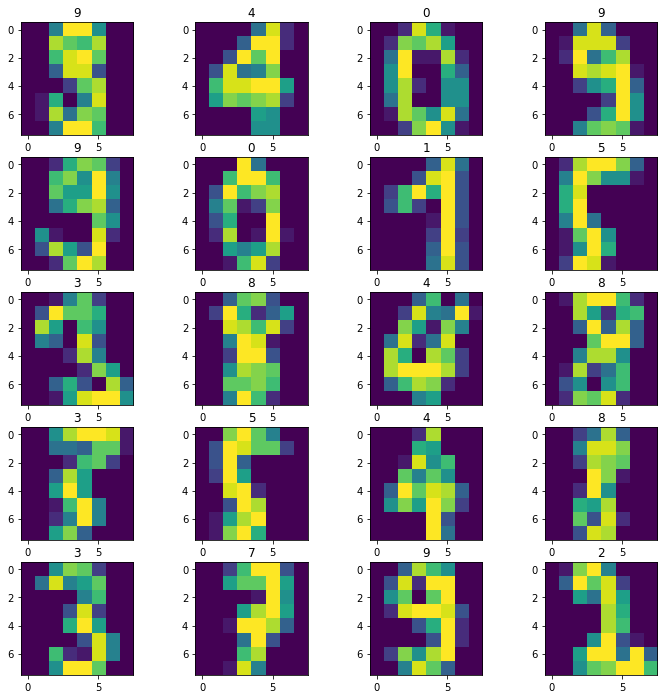

In [149]:
mnist_dataset = load_digits()
data = mnist_dataset.data

fig = plt.figure(figsize=(12, 12))
columns = 4
rows = 5
for i in range(1, columns * rows + 1):
    img_index = random.randint(0, len(mnist_dataset.data))
    img = mnist_dataset.images[img_index]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(mnist_dataset.target[img_index])
plt.show()

In [150]:
mnist_dataset.data[1].shape

(64,)

## Create data loader (custom)

In [179]:
class MyMnistDataset(torch.utils.data.Dataset):
    def __init__(self,  train=True):
        mnist = load_digits()
        mnist.data /= 16.
        x_train, x_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.2, train_size=0.8)
        if train:
            self.x_data, self.y_data = x_train, y_train
        else:
            self.x_data, self.y_data = x_test, y_test

    def __getitem__(self, item):
        data = self.x_data[item].reshape(8,8)
        data = torch.from_numpy(data)
        data = data.float()
        print(data.shape)
        return data.unsqueeze(0), torch.tensor(self.y_data[item])

    def __len__(self):
        return len(self.x_data)

### Trying our custom dataset
We will wrap it in casual DataLoader

In [180]:
ds = MyMnistDataset(True)
dl = DataLoader(ds, batch_size=16)

for x_data, y_data in dl:
    sample_image = x_data[0]
    sample_lable = y_data[0]
    print(sample_lable,  " sample label")
    print(sample_image,  " sample image")

torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
torch.Size([8, 8])
tensor(7, dtype=torch.int32)  sample label
tensor([[[0.0000, 0.0000, 0.1250, 0.6250, 0.6250, 0.7500, 0.9375, 0.6250],
         [0.0000, 0.0000, 0.5625, 1.0000, 0.7500, 0.5000, 0.9375, 0.3750],
         [0.0000, 0.0000, 0.8125, 0.5625, 0.0000, 0.2500, 0.7500, 0.0625],
         [0.0000, 0.0625, 1.0000, 0.1875, 0.0625, 0.8125, 0.1250, 0.0000],
         [0.0000, 0.0000, 0.3125, 0.0000, 0.5625, 0.4375, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.1875, 0.8125, 0.0625, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.7500, 0.4375, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.8750, 0.1250, 0.0000, 0.0000, 0.0000]]])  sample image
torch.Size([8, 8])
torch.Size([8, 8])

In [181]:
len(ds)

1437

## Visualize data after normalizing

In [182]:
# example = enumerate(dl)
# batch_idx , (example_data, example_target) = next(example)
# fig = plt.figure(figsize=(12, 8))
# columns = 2
# rows = 5
# for i in range(1, columns * rows + 1):
#     batch_idx , (example_data, example_target) = next(example)
#     img = example_data[0]
#     fig.add_subplot(rows, columns, i)
#     plt.imshow(img.view(8,8))
#     plt.title(example_target[0].item())
# plt.show()

## Create convolution neural network

In [336]:
class ConvolutionNetwork(nn.Module):
    def __init__(self):
        super(ConvolutionNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=2)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=2)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(3*3, 20)
        self.fc2 = nn.Linear(20, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        print(x.shape)
        return F.log_softmax(x, dim=-1)

### Check if cuda is available

In [337]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [338]:
model = ConvolutionNetwork().to(device)
lr = 1e-1
epochs = 1000
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
ds = MyMnistDataset()
dl = DataLoader(ds, batch_size=16)
# examples = enumerate(dl)
# batch_idx, (example_data, example_target) = next(examples)
# example_data.shape

In [339]:
def make_train_step(model, optimizer):
    def train_step(x,y):
        model.train()
        yhat = model(x)
        loss_calculation = F.cross_entropy(yhat, y)
        loss_calculation.backwards()
        optimizer.step()
        optimizer.zero_grad()
        return loss_calculation.item()
    return train_step

In [340]:
train_step = make_train_step(model, optimizer)
losses = []
for epoch in range(epochs):
    for train_value, train_label in ds:
        train_value = train_value.to(device)
        train_label = train_label.to(device)

        loss = train_step(train_value, train_label)
        losses.append(loss)
print(model.state_dict())

torch.Size([8, 8])
torch.Size([10, 3, 3])
torch.Size([10, 10])


ValueError: Expected input batch_size (10) to match target batch_size (0).